In [188]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sn
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn-dark')

In [152]:
temperature = pd.read_csv(r'Lecture Data\temperature_DK.csv')
cases = pd.read_csv(r'Lecture Data\Municipality_cases_time_series_formatted.csv')
tested = pd.read_csv(r'Lecture Data\Municipality_tested_persons_time_series_formatted.csv')
deaths = pd.read_csv(r'Lecture Data\Deaths_over_time.csv',sep=';')
municipality_code = pd.read_excel(r'Lecture Data\Municipality_codes.xlsx')
municipalities = pd.read_excel(r'Lecture Data\municipalities.xlsx')

In [153]:
cases.rename(columns={'SampleDate': 'Date'}, inplace=True)
data = cases.set_index('Date',drop=True)

In [154]:
data = data.merge(tested,on=['Date','Kommune'],how='outer')

In [155]:
data = data.merge(municipality_code,on=['Kommune'],how='outer')

In [156]:
deaths.rename(columns={'Dato': 'Date'}, inplace=True)

In [157]:
i = deaths[deaths.Date == 'I alt'].index
deaths = deaths.drop(i)

In [158]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y %H.%M')

In [159]:
deaths['Date'] = pd.to_datetime(deaths['Date'], format='%Y/%m/%d')

In [160]:
data = data.merge(deaths,on=['Date'],how='outer')

In [161]:
temperature['Time'] = pd.to_datetime(temperature['Time'], format='%Y-%m-%d %H:%M:%S')

In [163]:
temperature['Time'] = pd.to_datetime(temperature.Time).dt.tz_localize(None)

In [164]:
temperature.rename(columns={'Time': 'Date'}, inplace=True)

In [165]:
temperature = temperature.set_index('Date',drop=True)

In [166]:
temperature = temperature.apply(lambda x: x.str.replace(',','.'))

In [167]:
temperature = temperature.apply(pd.to_numeric)

In [168]:
temperature = temperature.resample('d').mean()

In [171]:
data = data.merge(temperature,on=['Date'],how='outer')

<AxesSubplot:>

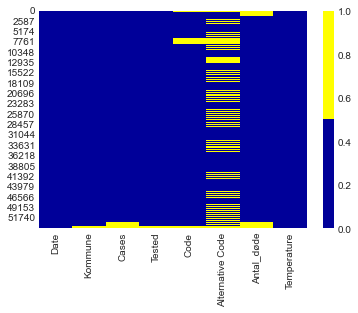

In [172]:
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sn.heatmap(data.isnull(), cmap=sn.color_palette(colours))

In [181]:
data

,Date,Kommune,Cases,Tested,Code,Alternative Code,Antal_døde,Temperature
0,2020-02-26,Roskilde,1.0,3.0,265.0,"255, 263",NaN,1.433333
1,2020-02-26,Copenhagen,0.0,4.0,NaN,NaN,NaN,1.433333
2,2020-02-26,Aarhus,0.0,2.0,NaN,NaN,NaN,1.433333
3,2020-02-26,Frederiksberg,0.0,1.0,147.0,NaN,NaN,1.433333
4,2020-02-26,Kalundborg,0.0,0.0,326.0,"301, 309, 317, 319, 323",NaN,1.433333
...,...,...,...,...,...,...,...,...
54321,2021-08-12,NaN,NaN,NaN,NaN,NaN,NaN,18.629167
54322,2021-08-13,NaN,NaN,NaN,NaN,NaN,NaN,20.187500
54323,2021-08-14,NaN,NaN,NaN,NaN,NaN,NaN,16.633333
54324,2021-08-15,NaN,NaN,NaN,NaN,NaN,NaN,17.654167


# Preliminary Data Visualization

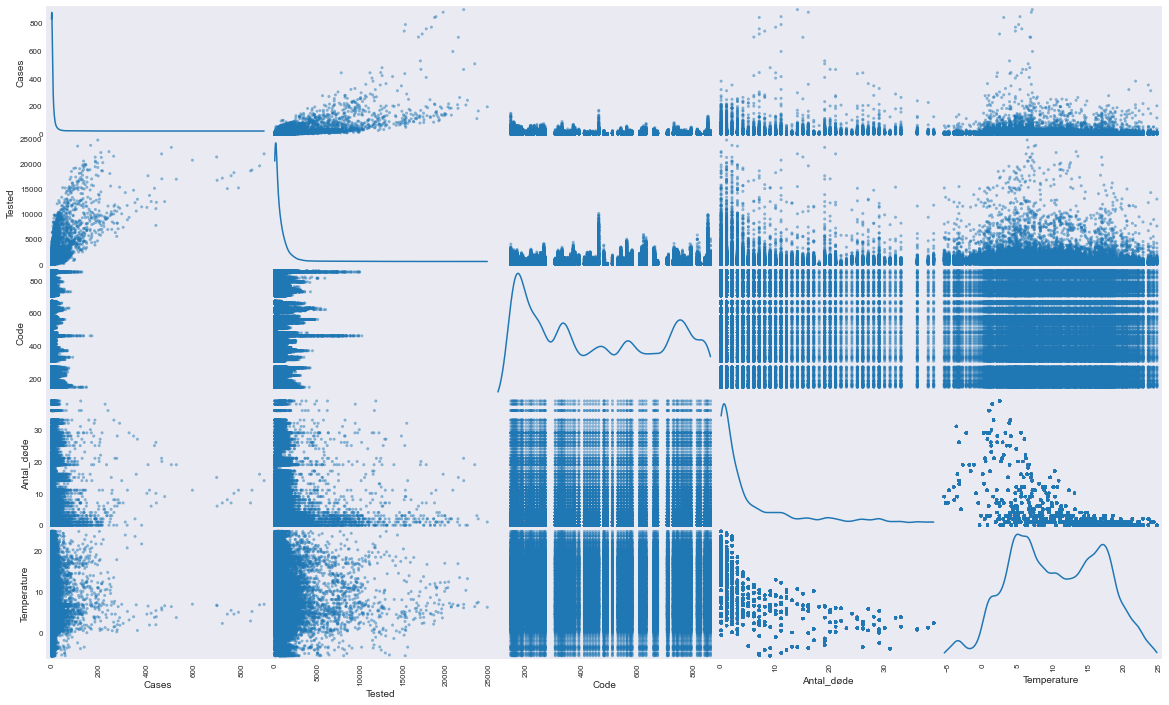

In [180]:
scatter_matrix(data, figsize=(20, 12), diagonal="kde");

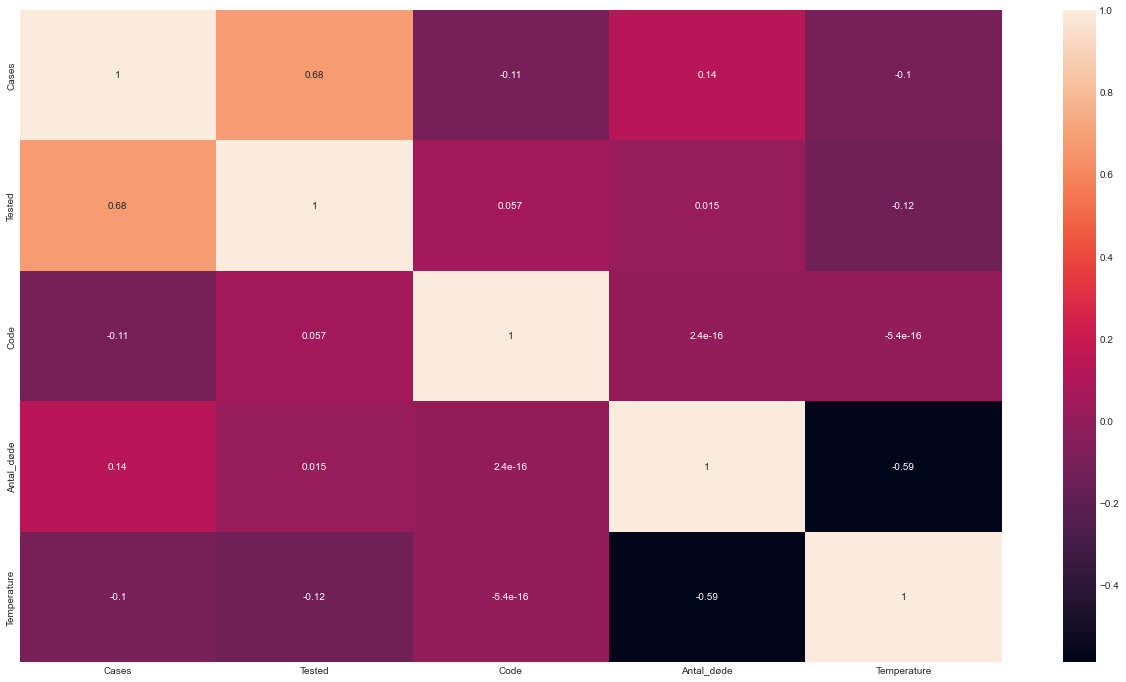

In [177]:
corrMatrix = data.corr()

fig, ax = plt.subplots(figsize=(22,12))  
sn.heatmap(corrMatrix, annot=True)
plt.show()

C:\Users\danho\AppData\Local\Temp\1/ipykernel_12796/3346438594.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


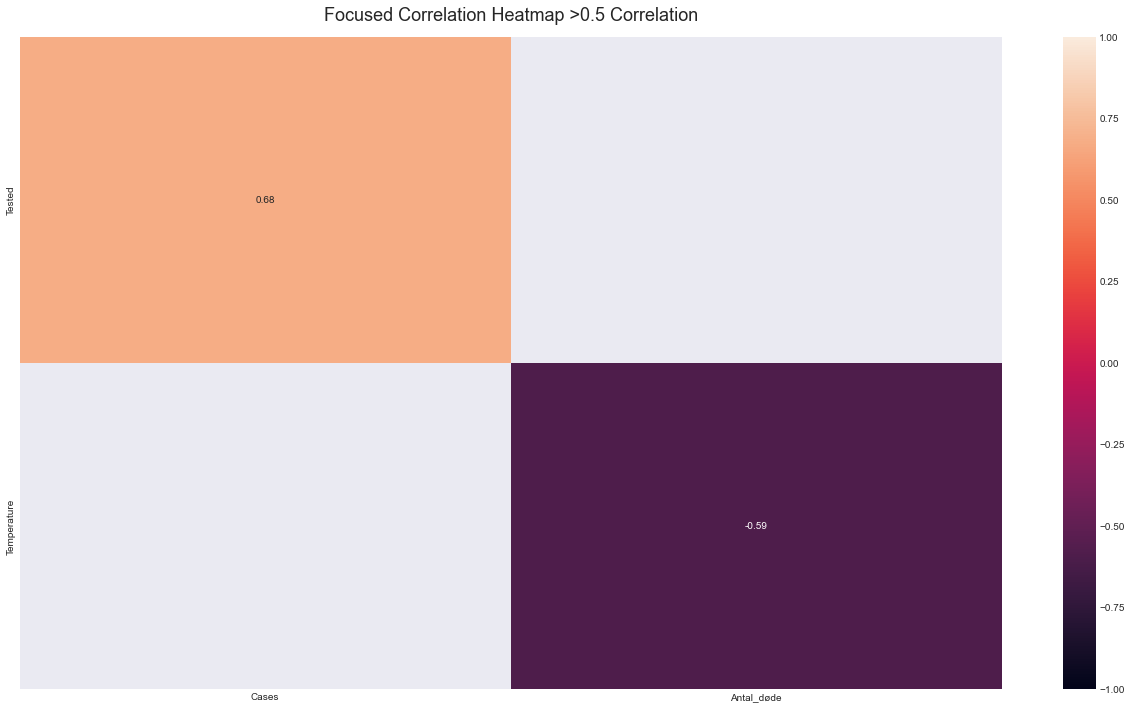

In [178]:
corr = corrMatrix

mask = np.triu(np.ones_like(corr, dtype=np.bool))
cut_off = 0.5  # only show cells with abs(correlation) at least this value
extreme_1 = 0.75  # show with a star
extreme_2 = 0.85  # show with a second star
extreme_3 = 0.90  # show with a third star
mask |= np.abs(corr) < cut_off
corr = corr[~mask]  # fill in NaN in the non-desired cells

remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]

annot = [[f"{val:.2f}"
          + ('' if abs(val) < extreme_1 else '\n★')  # add one star if abs(val) >= extreme_1
          + ('' if abs(val) < extreme_2 else '★')  # add an extra star if abs(val) >= extreme_2
          + ('' if abs(val) < extreme_3 else '★')  # add yet an extra star if abs(val) >= extreme_3
          for val in row] for row in corr.to_numpy()]

fig, ax = plt.subplots(figsize=(22,12)) 
heatmap = sn.heatmap(corr, vmin=-1, vmax=1, annot=annot, fmt='')
heatmap.set_title('Focused Correlation Heatmap >0.5 Correlation', fontdict={'fontsize': 18}, pad=16)
plt.show()